# Predicción de lluvia usando regresión logística

#Rain in Australia
Descripción: This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Instancias: 145461

Atributos: 23

0. Date (AAAA-MM-DD): The date of observation
1. Location: The common name of the location of the weather station.
2. MinTemp: The minimum temperature in degrees celsius
3. MaxTemp: The maximum temperature in degrees celsius
4. Rainfall: The amount of rainfall recorded for the day in mm
5. Evaporation: The so-called Class A pan evaporation (mm) in the 24 hours to 9am
6. Sunshine: The number of hours of bright sunshine in the day.
7. WindGustDir: The direction of the strongest wind gust in the 24 hours to midnight
8. WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
9. WindDir9am: Direction of the wind at 9am

# 1. Acceso a drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Importando librerías

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# 3. Lectura del dataset

In [ ]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.2 Regresión Logística'
name = 'weatherAUS.csv'

In [ ]:
raindf = pd.read_csv(os.path.join(path,name))
raindf.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Generando una copia del dataframe

In [ ]:
raindfc = raindf.copy()
raindf.shape

(145460, 23)

**Revisando visualmente si hay NaNs**

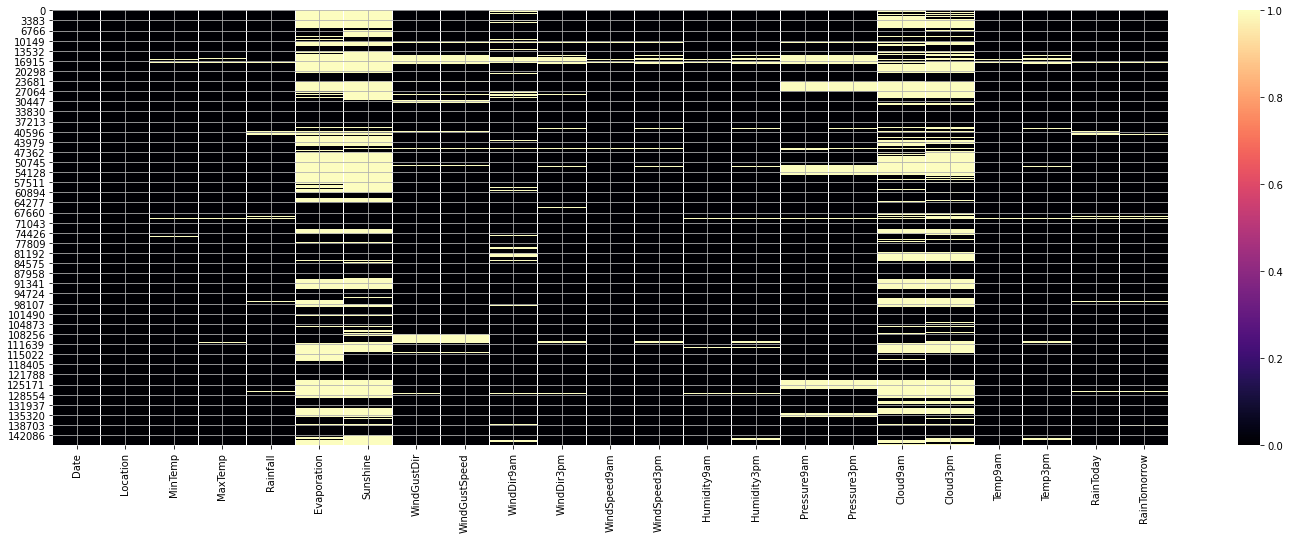

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(raindf.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

# 4. Limpieza de los datos

**Eliminando la columna 'Date'**

In [ ]:
raindf.drop(['Date'], axis=1, inplace=True)

**Eliminación o Imputación de valores faltantes**

In [ ]:
for i in range(raindf.shape[1]-1):
  raindf = raindf[raindf.iloc[:,i+1].notnull()]

**¿Con cuántas instancias nos quedamos?**

In [ ]:
raindf.shape

(56420, 22)

**Verificando si aún hay valores faltantes**

In [ ]:
print ('Conteo de valores faltantes: \n')
print (raindf.isna().sum())

Conteo de valores faltantes: 

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


**Guardando los nombres de la lista de características**

In [ ]:
features = raindf.columns.tolist()[:-1]
print(features)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


**Guardando los valores que puede tomar la variable dependiente**

In [ ]:
RainLabels = raindf['RainTomorrow'].unique()
print(RainLabels)

['No' 'Yes']


# 6. Codificación y Escalamiento 

**¿De qué tipo son las columnas (object=categórica, float64=numérica)?**

In [ ]:
raindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56420 entries, 6049 to 142302
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       56420 non-null  object 
 1   MinTemp        56420 non-null  float64
 2   MaxTemp        56420 non-null  float64
 3   Rainfall       56420 non-null  float64
 4   Evaporation    56420 non-null  float64
 5   Sunshine       56420 non-null  float64
 6   WindGustDir    56420 non-null  object 
 7   WindGustSpeed  56420 non-null  float64
 8   WindDir9am     56420 non-null  object 
 9   WindDir3pm     56420 non-null  object 
 10  WindSpeed9am   56420 non-null  float64
 11  WindSpeed3pm   56420 non-null  float64
 12  Humidity9am    56420 non-null  float64
 13  Humidity3pm    56420 non-null  float64
 14  Pressure9am    56420 non-null  float64
 15  Pressure3pm    56420 non-null  float64
 16  Cloud9am       56420 non-null  float64
 17  Cloud3pm       56420 non-null  float64
 18  Te

**Ahora que conocemos nuestras variables categóricas, crearemos una lista con sus nombres**

In [ ]:
cat_columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

**Codifiquemos estas columnas**

In [ ]:
EncoderObj = {}
for col in cat_columns:
  labelencoder = LabelEncoder()
  raindf[col] = labelencoder.fit_transform(raindf[col])
  EncoderObj[col] = labelencoder

In [ ]:
raindf.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,4,17.9,35.2,0.0,12.0,12.3,11,48.0,1,12,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
6050,4,18.4,28.9,0.0,14.8,13.0,8,37.0,10,10,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
6052,4,19.4,37.6,0.0,10.8,10.6,5,46.0,5,6,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
6053,4,21.9,38.4,0.0,11.4,12.2,14,31.0,14,15,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
6054,4,24.2,41.0,0.0,11.2,8.4,14,35.0,7,14,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0


**Dividir el dataframe en dos: Vars independientes y Var dependiente**

In [ ]:
X = raindf.iloc[:,:-1]
y = raindf.iloc[:,-1]

**Escalando las variables independientes de 0 a 1**

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X.loc[:,:] = scaler.fit_transform(X)

In [ ]:
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
6049,0.16,0.645669,0.706818,0.0,0.147783,0.848276,0.733333,0.339130,0.066667,0.800000,0.061538,0.243243,0.20,0.13,0.430718,0.441748,0.250,0.555556,0.680798,0.700472,0.0
6050,0.16,0.658793,0.563636,0.0,0.182266,0.896552,0.533333,0.243478,0.666667,0.666667,0.261538,0.229730,0.30,0.08,0.540902,0.566343,0.125,0.111111,0.523691,0.549528,0.0
6052,0.16,0.685039,0.761364,0.0,0.133005,0.731034,0.333333,0.321739,0.333333,0.400000,0.430769,0.175676,0.42,0.22,0.530885,0.519417,0.125,0.666667,0.733167,0.735849,0.0
6053,0.16,0.750656,0.779545,0.0,0.140394,0.841379,0.933333,0.191304,0.933333,1.000000,0.061538,0.054054,0.37,0.22,0.537563,0.517799,0.125,0.555556,0.743142,0.752358,0.0
6054,0.16,0.811024,0.838636,0.0,0.137931,0.579310,0.933333,0.226087,0.466667,0.933333,0.230769,0.148649,0.19,0.15,0.504174,0.490291,0.125,0.666667,0.855362,0.799528,0.0


# 5. Exploración de los datos 

**Observemos las correlaciones e histogramas de las variables independientes numéricas de la lista num_cols... ¿Qué observas?**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


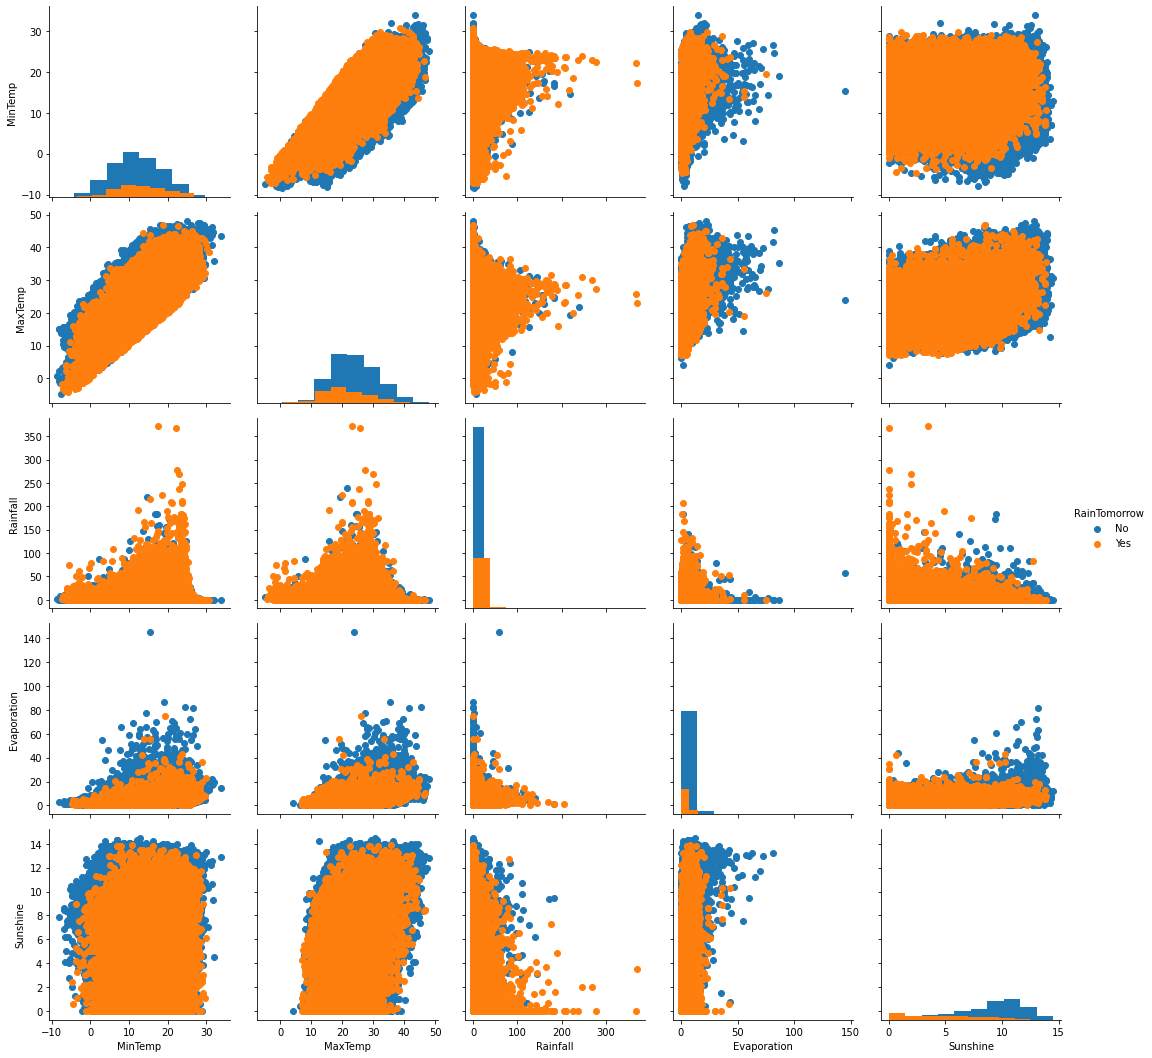

In [ ]:
num_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine']
#	WindGustSpeed		WindSpeed9am	WindSpeed3pm	Humidity9am	Humidity3pm	Pressure9am	Pressure3pm	Cloud9am	Cloud3pm	Temp9am	Temp3pm	
g = sns.PairGrid(data=raindfc, vars=num_columns, hue='RainTomorrow', size=3)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

**Visualicemos cuántas instancias hay de cada tipo para la variable dependiente... ¿Qué pasa?**

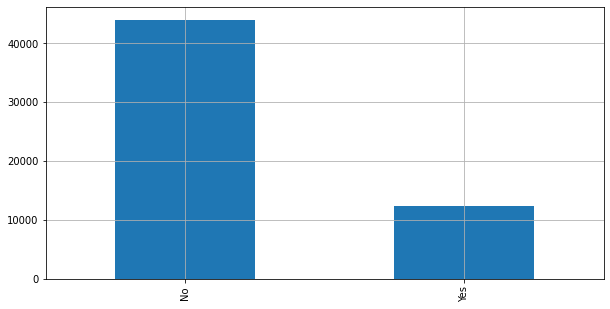

In [ ]:
p = raindf['RainTomorrow'].value_counts().plot(kind='bar', figsize=(10,5), grid=True)
p.set_xticklabels(RainLabels)
plt.show()


**Contemos las instancias para NO (0) y para SI (0)**

In [ ]:
# Instancias con NO
no = raindf[raindf.RainTomorrow == 0]
# Instancias con YES
yes = raindf[raindf.RainTomorrow == 1]
print(len(yes))
print(len(no))

12427
43993


**Submuestreo**

In [ ]:
# estrategia de submuestreo
undersample = RandomUnderSampler(sampling_strategy='majority')
# ajustar y aplicar el submuestreo
X, y = undersample.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Visualiceos su distribución de nuevo**

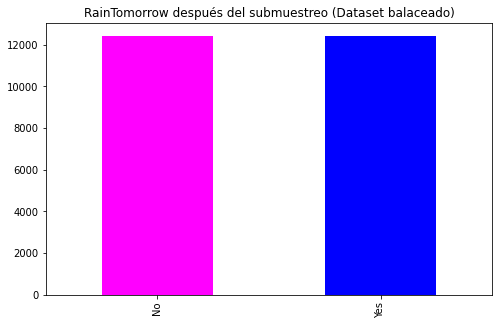

In [ ]:
fig = plt.figure(figsize = (8,5))
p = pd.Series(y).value_counts(normalize = False).plot(kind='bar', color= ['magenta','blue'])
p.set_xticklabels(RainLabels)
plt.title('RainTomorrow después del submuestreo (Dataset balaceado)')
plt.show()

**Volvamos a contar las instancias de NO y de SI**

In [ ]:
# Instancias con NO
no = y[y == 0]
# Instancias con YES
yes = y[y == 1]
print(len(yes))
print(len(no))

12427
12427


**Dado que está balanceado definamos los persos de cada clase**

In [ ]:
pesos = [0.5, 0.5]
print(pesos)

[0.5, 0.5]


# 7. Predicción con regresión logística

**Definamos a nuestro clasificador de la clase LogisticRegression**

In [ ]:
logreg = LogisticRegression(max_iter=200)

**Usando una validación de 10 folds definamos a nuestro objeto kfold**




In [ ]:
kfold = KFold(n_splits=10, shuffle=True)

**Obteniendo el score alcanzado por el clasificador**

In [ ]:
score = cross_val_score(logreg, X, y, cv=kfold, scoring="accuracy")
print(score)

[0.79927595 0.80571199 0.80450523 0.79766693 0.80402414 0.78108652
 0.79758551 0.80241449 0.8        0.80201207]


**Predicciones**

In [ ]:
y_pred = cross_val_predict(logreg, X, y, cv=10)

**Matriz de confusión**

In [ ]:
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.grid(False)
    plt.show()

**Interpretemos la matriz de confusión**

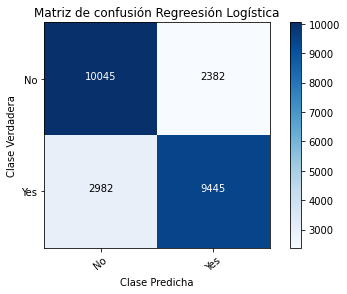

In [ ]:
predictions = np.float32(y_pred)
true_labels = np.float32(y)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(2))
tit = 'Matriz de confusión Regreesión Logística'
plot_confusion_matrix(cnf_matrix,RainLabels, tit, normalize=False)

In [ ]:
def sens_spec(cls_names, y_true, y_pred, pesos):
  sensitivity = []
  specificity = []
  acc=[]
  for i,name in enumerate(cls_names):
    TP = np.sum((y_true==name) & (y_pred==name))
    TN = np.sum((y_true!=name) & (y_pred!=name))
    FP = np.sum((y_true!=name) & (y_pred==name))
    FN = np.sum((y_true==name) & (y_pred!=name))
    sensitivity.append(TP/(TP+FN))
    specificity.append(FP/(TN+FP))
    acc.append(TP/(TP+FP))
  sensitivity.append(sum([x*y for x,y in zip(sensitivity,pesos)]))
  specificity.append(sum([x*y for x,y in zip(specificity,pesos)]))
  acc.append(sum([x*y for x,y in zip(acc,pesos)]))
  return sensitivity, specificity, acc

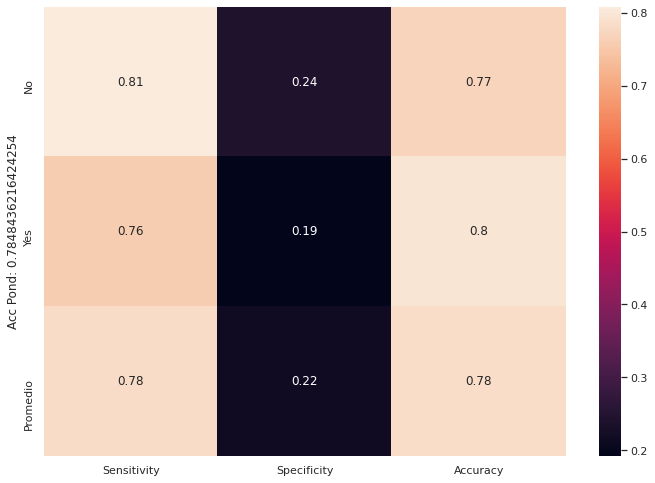

In [ ]:
      sensitivity, specificity, acc = sens_spec(range(2), true_labels, predictions, pesos)
      d = {'Sensitivity':sensitivity, 'Specificity':specificity, 'Accuracy':acc}
      ind = list(RainLabels)+['Promedio']
      df = pd.DataFrame(d, index=ind)
      index = df.index
      precprom = sum([x*y for x,y in zip(acc,pesos)])
      index.name = 'Acc Pond: %s'%precprom
      sns.set(rc={'figure.figsize':(11.7,8.27)})
      sns.heatmap(df, annot=True)